In [1]:
###############################################################################
#                                                                             #
#                                                                             #
# Basic tests of SYNEX functions to make sure everything installed correctly. #
#                                                                             #
#                                                                             #
###############################################################################
%matplotlib inline

In [2]:
###########################
#                         #
# Basic starting tests... #
#                         #
###########################

In [3]:
# Import starting packages
import os,sys

# Define SYNEX_PATH variable, add to path if not already there
try:
    from SYNEX.SYNEX_Utils import SYNEX_PATH
except:
    SYNEX_PATH=os.popen('pwd').read().split("SYNEX")[0]+"SYNEX"
    sys.path.insert(1, SYNEX_PATH)

# print(SYNEX_PATH) ### Check this is right.

In [4]:
### Continue importing ###


# required packages
from astropy.time import Time
import numpy as np
import pandas as pd
from scipy import stats
import time
from astropy.time import Time


# gwemopt
import gwemopt


# lisabeta
import lisabeta
import lisabeta.lisa.lisa_fisher as lisa_fisher
import lisabeta.lisa.lisa as lisa
import lisabeta.lisa.lisatools as lisatools
import lisabeta.lisa.pyLISAnoise as pyLISAnoise
import lisabeta.lisa.pyresponse as pyresponse
import lisabeta.tools.pytools as pytools
import lisabeta.pyconstants as pyconstants
import lisabeta.inference.inference as inference


# synex
import SYNEX.SYNEX_Utils as SYU
import SYNEX.SYNEX_Sources as SYSs
import SYNEX.SYNEX_Detectors as SYDs
import SYNEX.segments_athena as segs_a


# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
try:
    import ligo.skymap.plot
    cmap = "cylon"
except:
    cmap = 'PuBuGn'
pylab_params = {'legend.fontsize': 4,
         'axes.labelsize': 4,
         'axes.titlesize': 4,
         'xtick.labelsize': 4,
         'ytick.labelsize': 4,
         'lines.markersize': 0.7,
         'lines.linewidth': 0.7,
         'font.size': 4}
pylab.rcParams.update(pylab_params)


# Stop warnings about deprecated methods...
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Using MPI or not
try:
    from mpi4py import MPI
except ModuleNotFoundError:
    MPI = None

use_mpi=False
is_master = True
mapper = map
if MPI is not None:
    MPI_size = MPI.COMM_WORLD.Get_size()
    MPI_rank = MPI.COMM_WORLD.Get_rank()
    comm_global = MPI.COMM_WORLD
    use_mpi = (MPI_size > 1)
    if use_mpi:
        # print("MPI rank/size: %d / %d" % (MPI_rank, MPI_size), flush=True)
        pool = ptemcee.mpi_pool.MPIPool(debug=False)
        is_master = pool.is_master()
        mapper = pool.map
    else:
        # print("No MPI", flush=True)
        is_master = True
        mapper = map

In [6]:
#####################
#                   #
# lisabeta tests... #
#                   #
#####################

In [7]:
# LISA object params
LISA_base_kwargs = {"TDI":'TDIAET',"verbose":False}

# Create LISA
LISA = SYDs.LISA(**LISA_base_kwargs)







# Source object parameters
# NB Dec = beta and Ra = lambda (more or less)
Merger_kwargs = {
        "q": 3, "M": 1e7, "z": 2.5, "chi1": 0.,
        "chi2": 0., "beta" : np.pi/3., "lambda" : np.pi/6.,
        "inc": 40.3*np.pi/180., "psi": 0.,  "approximant" : 'IMRPhenomHM',
        "Lframe":True, "DeltatL_cut":-14*24*60*60,
        "verbose":False,
        "out_file":"Test_system",
        "ExistentialFileName":SYNEX_PATH+"/Saved_Source_Dicts/Test_system.dat",
        "JsonFile":"Test_system"
}

# Create source
Merger=SYSs.SMBH_Merger(**Merger_kwargs)





# Inference params definition with prior ranges and types
inference_params = {
    "infer_params": ["chi1", "chi2", "dist", "inc", "phi", "lambda", "beta", "psi"],
    "params_range": [[-1., 1.], [-1., 1.], [5e3, 2e5], [0.,np.pi], [-np.pi, np.pi], [-np.pi, np.pi], [-np.pi/2.,np.pi/2.], [0.,np.pi]],
    "prior_type": ["uniform", "uniform", "uniform", "sin", "uniform", "uniform", "cos", "uniform"],
    "wrap_params": None
}

# Parameters governing MCMC inference -- NB: samples used are SMALL to reduce runtime. Larger numbers commented out are recommended for proper inference runs.
RunTimekwargs = {
    "print_info": True,
    "n_walkers":  32, # 96,
    "n_iter": 10000,
    "burn_in": 5000,
    "autocor_method": "autocor_new",
    "thin_samples": True,
    "TDI": "TDIAET",
    "multimodal": True,
    "multimodal_pattern": "8modes",
    "p_jump": 0.5,
    "init_method": "fisher",
    "skip_fisher": False,
    "n_temps": 10,
    "output_raw":False
}



# Write params to json file
SYU.WriteParamsToJson(Merger,LISA,inference_params,is_master,**RunTimekwargs)
print("Json file created for source at: ../SYNEX/"+Merger.JsonFile.split("/SYNEX/")[-1])



Json file created for source at: ../SYNEX/inference_param_files/Test_system.json


Merger detected by LISA with SNR: 5.194062056826905


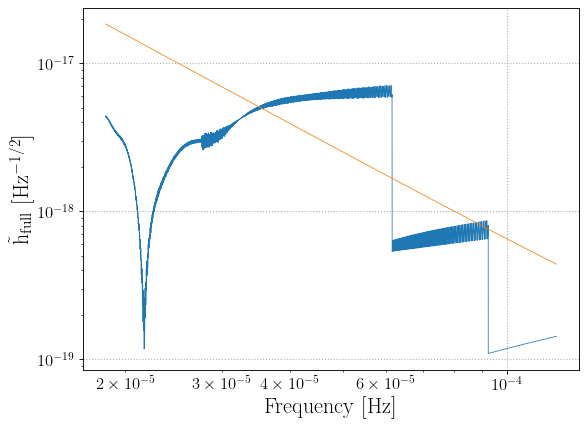

In [8]:
### Basic tests of source

# SNR
SNR, freqs, h_full, Snvals = SYU.ComputeSNR(Merger, LISA, freqs=None, Lframe=False, ReturnAllVariable=True)
print("Merger detected by LISA with SNR:",SNR)

# convert to params dictionaries -- inverse function is SYU.ParamsToClasses(input_params,CollectionMethod="Inference",**kwargs)
[param_dict, waveform_params, _ ] = SYU.ClassesToParams(Merger,LISA,"Inference")

# Get the detection data
tdifreqseries_base = SYU.GetSMBHGWDetection_FreqSeries(Merger, LISA)

# Output stuff into useful forms - 22 mode`
modes = tdifreqseries_base['modes']

# Compute noise
SYU.ComputeDetectorNoise(Merger, LISA)

# Extract the noise for plotting
Snvals = LISA.Snvals

# Create the container for the full waveform
freqs = ['linear', None]
freqs = SYU.GenerateFreqs(freqs, param_dict, **waveform_params)
h_full = {}
for chan in Snvals.keys(): # channels:
    h_full[chan] = np.zeros_like(freqs, dtype=complex)
    for lm in modes:
        h_full[chan] += tdifreqseries_base[lm][chan]

# Add higher harmonics to get the full waveform
h_full_tot = 0.
Snvals_tot = 0.
for chan in Snvals.keys():
    h_full_tot += h_full[chan]
    Snvals_tot += Snvals[chan]

# # Find the amp
# h_full_tot_amp = np.sqrt(h_full_tot*np.conj(h_full_tot))*np.sqrt(freqs)
h_full_tot_amp = abs(h_full_tot)*np.sqrt(freqs)

# Plot waveform
%matplotlib inline
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.figure(figsize=(8, 6), dpi=80)
plt.loglog(freqs, h_full_tot_amp)

# Plot noise
plt.loglog(freqs, np.sqrt(Snvals_tot))

# labels
plt.xlabel(r"Frequency [Hz]")
plt.ylabel(r"$\tilde{\mathrm{h}}_{\mathrm{full}}$ [Hz$^{-1/2}$]")

# Show and grid
# plt.grid()
plt.show()


In [9]:
# Begin inference if the test_file doesn't already exist (this takes time...)
t0 = time.time()
if not os.path.isfile(Merger.H5File):
    if use_mpi:
        os.system("time mpirun -np 10 python3 " + SYNEX_PATH + "/lisabeta/lisabeta/inference/ptemcee_smbh.py " + Merger.JsonFile + "> ${SLURM_SUBMIT_DIR}/lisabeta_test_run.txt")
    else:
        os.system("python3 " + SYNEX_PATH + "/lisabeta/lisabeta/inference/ptemcee_smbh.py " + Merger.JsonFile)
t1 = time.time()

print("Time to completion:",(t1-t0)/60,"min") ### Around 1hr27min. Reduce RunTimekwargs["n_walkers"], RunTimekwargs["n_iters"], and RunTimekwargs["burn_in"] if you don't want to wait.

### NOTE: you may need to run this in a seperate shell script when testing on cluster. See the SYNEX manual
#         for example shell scripts in section `Running on cluster'.



No MPI
Source parameters SSBframe:
{'m1': 7500000.0, 'm2': 2500000.0, 'chi1': 0.0, 'chi2': 0.0, 'Deltat': -266.2191895344559, 'dist': 20857.33264921759, 'inc': 0.7033676885537148, 'phi': 0.0, 'lambda': 2.7032880797877543, 'beta': 0.9407517166718674, 'psi': 2.3159145494265547, 'Lframe': False, 'Mchirp': 3662695.064479399, 'eta': 0.1875, 'M': 10000000.0, 'q': 3.0, 'chis': 0.0, 'chia': 0.0, 'chip': 0.0, 'chim': 0.0, 'chiPN': 0.0}
Source parameters Lframe:
{'m1': 7500000.0, 'm2': 2500000.0, 'chi1': 0.0, 'chi2': 0.0, 'Deltat': 0.0, 'dist': 20857.33264921759, 'inc': 0.7033676885537148, 'phi': 0.0, 'lambda': 0.5235987755982988, 'beta': 1.0471975511965976, 'psi': 0.0, 'Lframe': True, 'Mchirp': 3662695.064479399, 'eta': 0.1875, 'M': 10000000.0, 'q': 3.0, 'chis': 0.0, 'chia': 0.0, 'chip': 0.0, 'chim': 0.0, 'chiPN': 0.0}
Computing Fisher matrix...
Threshold max(t(SNR=1), 1d) used for Fisher: 0.133952 yr
Fisher covariance matrix:
[[ 1.51751506e-02 -3.44080314e-02  3.60321711e+03 -5.44818705e-03
  

Posterior sample length: 6400, number of infered parameters: 8


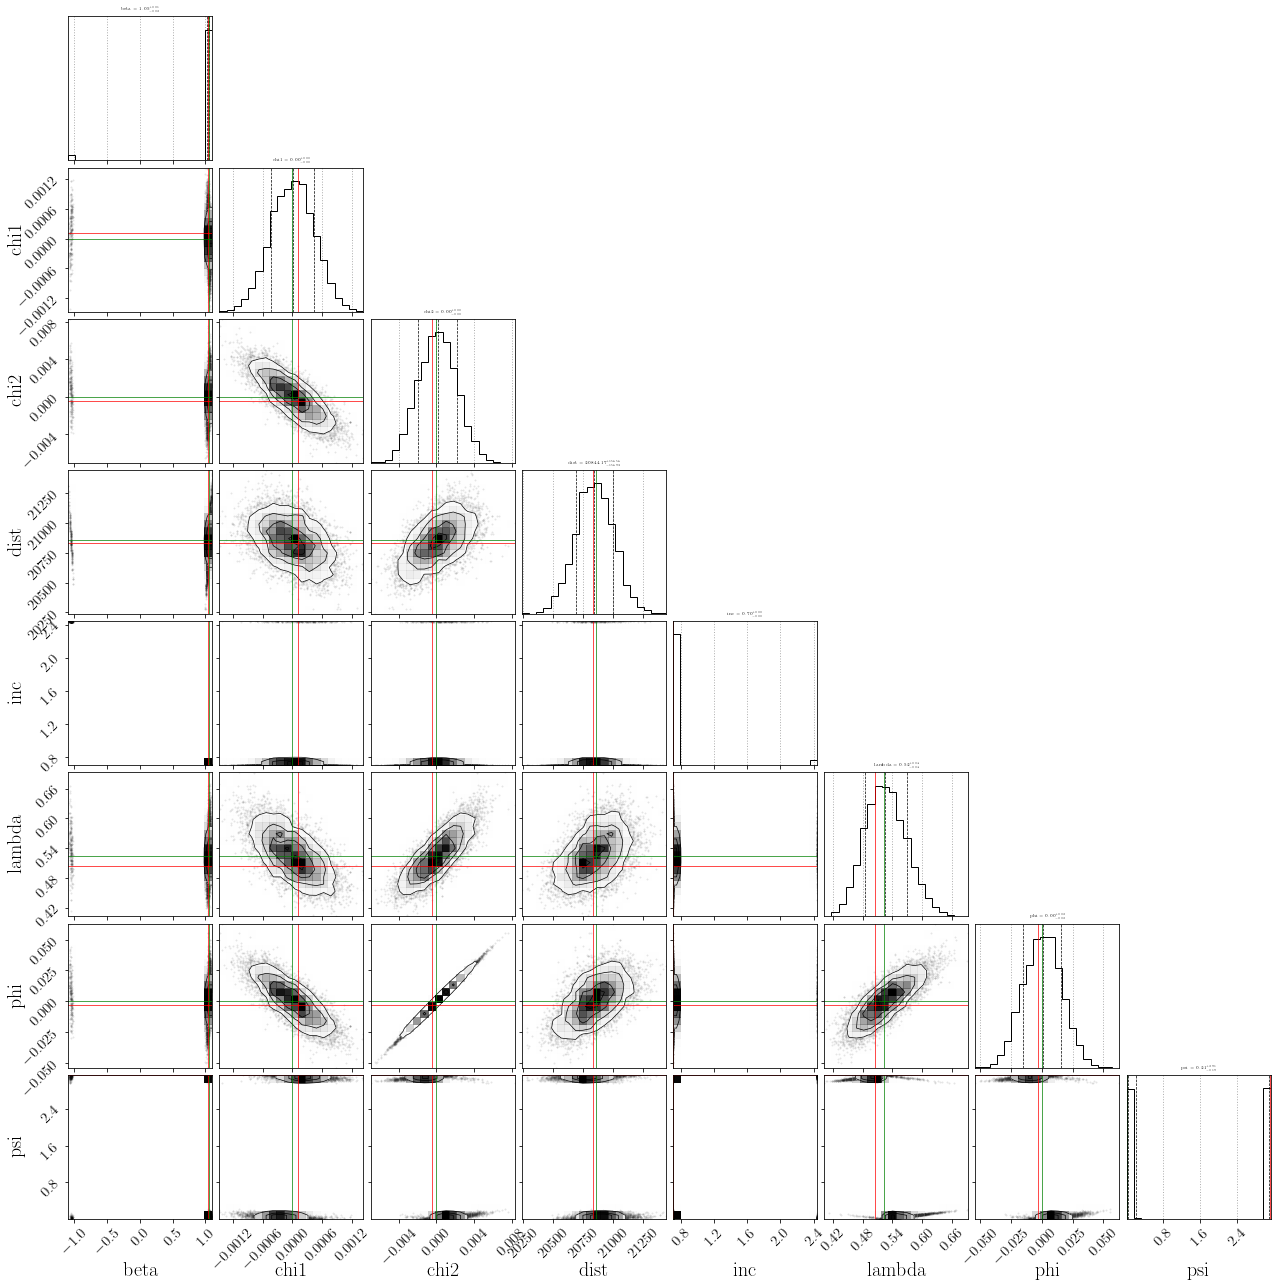

Posterior sample length: 6400, number of infered parameters: 8


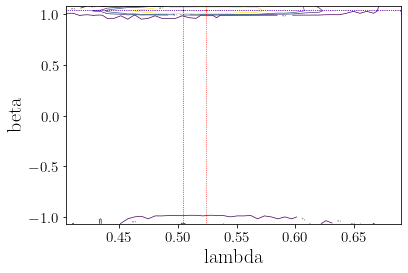

In [10]:
# See inference results
SYU.PlotInferenceData(Merger.H5File, SaveFig=False)

# See just lambda and beta (equivalent of RA and Dec)
# Note: convention in lisabeta is slightly different with RA <--> lattitude.
# Note: red is true location, blue is best fit posterior.
SYU.PlotInferenceLambdaBeta(Merger.H5File, bins=50, SkyProjection=False, SaveFig=False, return_data=False)

In [11]:
### Sky areas:

# Fisher sky area NB: No inference is needed, just an instance of system and LISA
fishercov = SYU.GetFisher_smbh(Merger, LISA, **{})
SkyArea = lisatools.sky_area_cov(fishercov, sq_deg=True, n_sigma=None, prob=0.90)

# Posterior sky area NB Inference must be run since we are calculating from MCMC posteriors... Precision vs time and all that.
SkyArea_post = SYU.GetTotSkyAreaFromPostData(Merger.JsonFile,ConfLevel=0.90)

# print
print(r"SkyArea according to Fisher inf. matrix:",SkyArea,r"deg^2")
print(r"SkyArea according to MCMC inference posteriors:",SkyArea_post*(180./np.pi)**2,r"deg^2")



Posterior sample length: 6400
Counted bin total population =  90.46726050945459 % of total population.
SkyArea according to Fisher inf. matrix: 41536.00484113656 deg^2
SkyArea according to MCMC inference posteriors: 32.38531899279673 deg^2


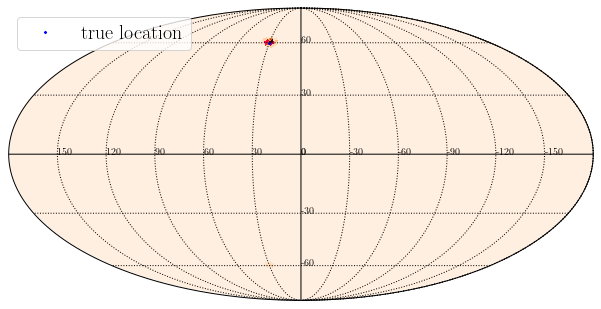

In [12]:
# Calculate the skymap
Merger.sky_map = Merger.H5File.split("inference_data")[0] + 'Skymap_files' + Merger.H5File.split("inference_data")[-1]
Merger.CreateSkyMapStruct(SkyMapFileName=None)

# See the skymap
SYU.PlotSkyMapData(Merger,SaveFig=False,plotName=None,DO_CONTOURS=False)

# Save everthing again
Merger.ExistentialCrisis()


In [13]:
####################
#                  #
# GWEMOpt tests... #
#                  #
####################

In [14]:
### Athena Object ###


# Telescope args
t0 = '2034-01-01T00:00:00.00'
t = Time(t0, format='isot', scale='utc').gps
Athena_kwargs={
                "ExistentialFileName":SYNEX_PATH+"/Saved_Telescope_Dicts/Athena_test.dat",
                "verbose":False,
                "telescope":"Athena_test",
                "orbitFile":"/SYNEX/orbit_files/Athena_test.dat", ## Need to include test for this
                "Tobs":np.array([0.,9.]),
                "tilesType" : "moc",
                "timeallocationType" : "powerlaw",
                "scheduleType" : "greedy",
                "doCalcTiles" : False,
                "Ntiles" : None,
                "frozenAthena" : False,
                "exposuretime" : 10000.,
                "min_observability_duration" : None,
                "inc" : 60.,
                "MeanRadius" : 750000000.,
                "semi_maj" : 750000000.,
                "eccentricity" : 0.4,
                "ArgPeriapsis" : 20.,
                "AscendingNode" : -10.,
                "phi_0" : 10.,
                "period" : 90.,
                "gps_science_start" : t,
                "mission_duration" : 2.,
                "filt_change_time" : 0.,
                "overhead_per_exposure" : 0.,
                "latitude" : 0.,
                "longitude" : 0.,
                "elevation" : 0.,
                "slew_rate" : 1.,
                "horizon" : 0.,
                "doMinimalTiling" : True,
                "readout" : 0.0001,
                "doSingleExposure" : True,
                "iterativeOverlap" : 0.,
                "maximumOverlap" : 1.0,
                "sat_sun_restriction" : 5.,
                "sat_earth_constraint" : 5.,
                "sat_moon_constraint" : 5.,
}

# Create Athena
Athena=SYDs.Athena(**Athena_kwargs)




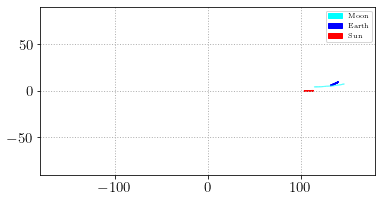

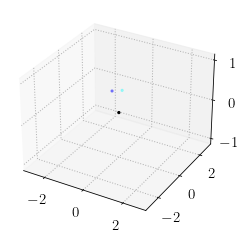

2.0 2.0


In [15]:
# Plot calculated Athena orbit -- size of circles correspond to angular diameters of each object as viewed by Athena
config_struct = segs_a.calc_telescope_orbit(Athena.detector_config_struct,SAVETOFILE=False)
SYU.PlotOrbit(config_struct, SaveFig=False) ## Might move this to within the Athena class to avoid dealing with config struct.

# Animate the trajectory to be fancy (might need to do at command line or save in order to render animation)
SYU.AnimateOrbit(config_struct,include_sun=False,SaveAnim=False)

print(Athena.detector_config_struct["mission_duration"], config_struct["mission_duration"])


In [16]:
# Generate EM flux based on a simple flat flux (this step is checked for inside tiling functions. we call it here just to show how to do it.)
EM_kwargs={}
Merger.GenerateEMFlux(fstart22=1e-4,TYPE="const",**EM_kwargs)

# Calculate CTR based on Athena object (this step is checked for inside tiling functions. we call it here just to show how to do it.)
Merger.GenerateCTR(Athena.ARF_file_loc_name,gamma=1.7)
  

In [17]:
# tile with GWEMOpt -- returns a list of detectors based on how many tilings asked for
Athena = SYU.TileSkyArea(sources=Merger,detectors=Athena,verbose=False)


Beginning tiling for 1 detectors, and 1 sources...
----------------------------------------------------------------------------------------------------
natural_nside = 32
nside = 256
Keeping 143/273251 tiles
Generating powerlaw schedule...
Generating schedule order...
Time to tile object no. 1 out of 1 : 25.291452884674072 s
----------------------------------------------------------------------------------------------------
Total time for 1 objects: 25.291994094848633 s
----------------------------------------------------------------------------------------------------


natural_nside = 256
nside = 256


<Figure size 432x288 with 0 Axes>

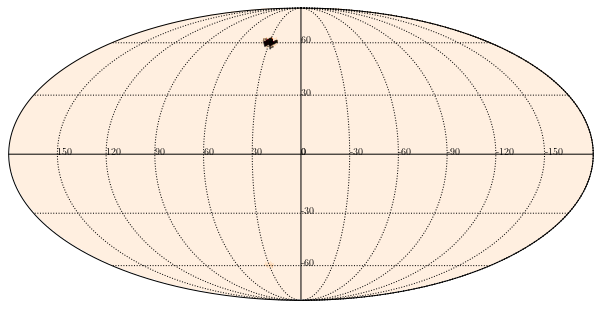

In [18]:
##### Plot stuff using gwemopt internal plotting functions

# gwemtop uses different architectures so need to reorder some stuff before plotting (SYNEX equiv. function in progress)
go_params,map_struct=SYU.PrepareGwemoptDicts(Merger,Athena[0])
TileStructs = {Ath.detector_config_struct["telescope"]:Ath.detector_tile_struct for Ath in Athena}

# Plot all tiles (SYNEX equiv. function in progress)
gwemopt.plotting.tiles(go_params, map_struct, TileStructs)


In [19]:
### Repeat but with cloning of Tobs

#### Filename is still adding exfimename to the filename...

# Define what we want to iterate tiling over
T_obs_array = [np.array([0.,1.]),np.array([0.,2.]),np.array([0.,3.]),np.array([0.,4.])]
cloning_params={"Tobs":T_obs_array} # Tobs in days = total observation time available for Athena to tile

# Some output options
SaveInSubFile = "Test_functions"
SaveFileCommonStart = "System"

# tile with GWEMOpt -- returns a list of detectors based on how many tilings asked for
Athenas_out = SYU.TileSkyArea(sources=Merger,base_telescope_params=Athena_kwargs,cloning_params=cloning_params,SaveInSubFile=SaveInSubFile,SaveFileCommonStart=SaveFileCommonStart,verbose=False)

# See now why we output a list of detectors;
print("\n\n")
print(len(Athenas_out),"detector params passed back from tiling function, with total observation times:")
for Ath in Athenas_out: print(Ath.detector_go_params["Tobs"])
    

1 / 1 with 4 / 4 detectors to tile, and  4 / 4 sources to tile.
Pre-tiling master node check: No source coverage...
natural_nside = 32
nside = 256
Keeping 143/273251 tiles
Generating powerlaw schedule...
Generating schedule order...
Post-tiling master node check: /Users/baird/Documents/LabEx_PostDoc/SYNEX/Saved_Source_Dicts/Test_system.dat
Time for telescope 1 / 4 by master rank: 23.088348865509033 s, with source coverage tileranges: [['2034-01-01T05:33:34.000', '2034-01-01T08:20:14.000'], ['2034-01-01T08:20:14.000', '2034-01-01T11:06:54.000']] 

Pre-tiling master node check: No source coverage...
natural_nside = 32
nside = 256
Keeping 143/273251 tiles
Generating powerlaw schedule...
Generating schedule order...
Post-tiling master node check: /Users/baird/Documents/LabEx_PostDoc/SYNEX/Saved_Source_Dicts/Test_system.dat
Time for telescope 2 / 4 by master rank: 23.151192903518677 s, with source coverage tileranges: [['2034-01-01T05:33:34.000', '2034-01-01T08:20:14.000'], ['2034-01-01T08:

In [20]:
# Access some interesting information regaring the tiling process
for i,Athena in enumerate(Athenas_out):
    print("Tobs:",Athena.detector_go_params["Tobs"],"found source",len(Athena.detector_source_coverage["Source tile timeranges (isot)"]),"times, collecting",sum(Athena.detector_source_coverage["Source photon counts"]),"total photons from the source at tile time ranges",Athena.detector_source_coverage["Source tile timeranges (isot)"],"\n")

# Put all the info into a pandas dataframe cause this is just easier
data=SYU.GetDataFrame(detectors=Athenas_out,SaveFile="Test_system")

###
# Note - the dataframe approach is very useful if at anytime you want to compare
# a set of detectors with completed tiling. You pass a list of savefile names and
# the function will hand back a dataframe with columns equal to the useful information.
###

# Show data
data.head()


Tobs: [0. 1.] found source 2 times, collecting 112.8004015943026 total photons from the source at tile time ranges [['2034-01-01T05:33:34.000', '2034-01-01T08:20:14.000'], ['2034-01-01T08:20:14.000', '2034-01-01T11:06:54.000']] 

Tobs: [0. 2.] found source 2 times, collecting 112.8004015943026 total photons from the source at tile time ranges [['2034-01-01T05:33:34.000', '2034-01-01T08:20:14.000'], ['2034-01-01T08:20:14.000', '2034-01-01T11:06:54.000']] 

Tobs: [0. 3.] found source 2 times, collecting 112.8004015943026 total photons from the source at tile time ranges [['2034-01-01T05:33:34.000', '2034-01-01T08:20:14.000'], ['2034-01-01T08:20:14.000', '2034-01-01T11:06:54.000']] 

Tobs: [0. 4.] found source 2 times, collecting 112.8004015943026 total photons from the source at tile time ranges [['2034-01-01T05:33:34.000', '2034-01-01T08:20:14.000'], ['2034-01-01T08:20:14.000', '2034-01-01T11:06:54.000']] 

Saving dataframe to: /Users/baird/Documents/LabEx_PostDoc/SYNEX/DataFrames/.h5


,M,q,chi1,chi2,lambda,beta,dist,DeltatL_cut,Tobs,exposuretime,n_photons_per_tile,n_photons,DaysToSourceExp
0,10000000,3.0,0.0,0.0,0.523599,1.047198,20857.332649,-1209600,1.0,10000.0,"[56.4002007971513, 56.40020079715129]",113,"[[0.231481481474475, 0.3472222222117125], [0.3..."
1,10000000,3.0,0.0,0.0,0.523599,1.047198,20857.332649,-1209600,2.0,10000.0,"[56.4002007971513, 56.40020079715129]",113,"[[0.231481481474475, 0.3472222222117125], [0.3..."
2,10000000,3.0,0.0,0.0,0.523599,1.047198,20857.332649,-1209600,3.0,10000.0,"[56.4002007971513, 56.40020079715129]",113,"[[0.231481481474475, 0.3472222222117125], [0.3..."
3,10000000,3.0,0.0,0.0,0.523599,1.047198,20857.332649,-1209600,4.0,10000.0,"[56.4002007971513, 56.40020079715129]",113,"[[0.231481481474475, 0.3472222222117125], [0.3..."


natural_nside = 256
nside = 256


<Figure size 432x288 with 0 Axes>

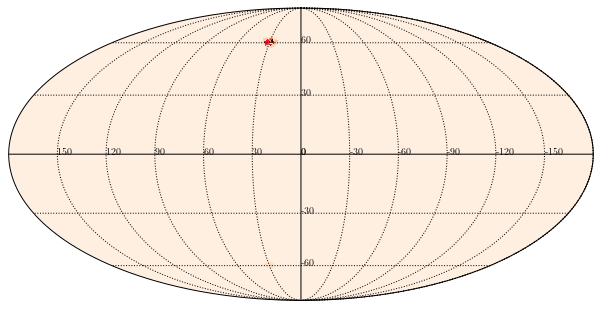

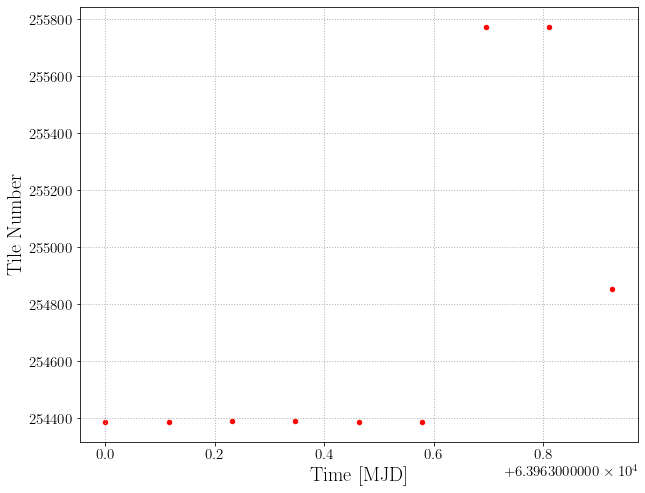

<Figure size 432x288 with 0 Axes>

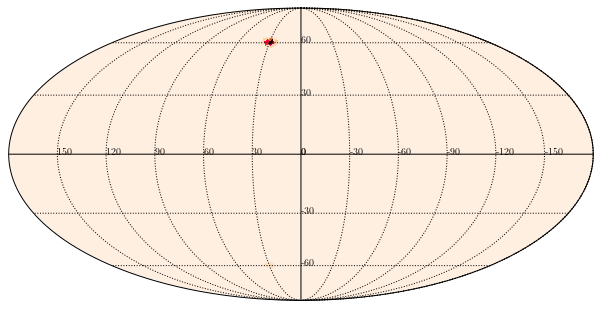

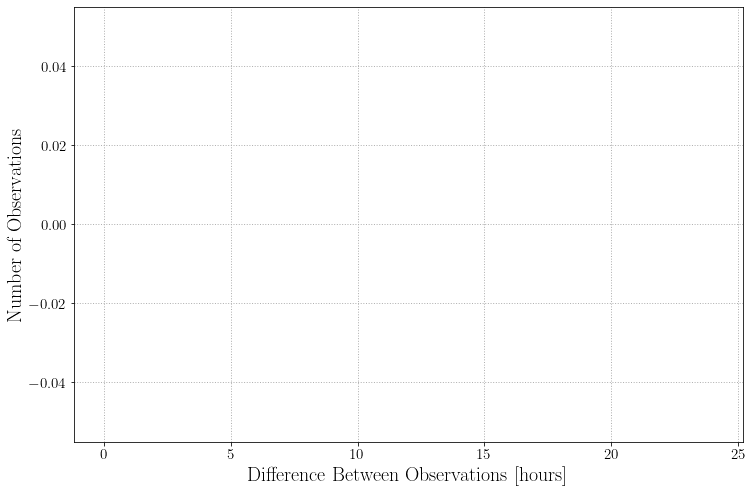

Athena_test_Tobs_SourceExName_1: 0/9


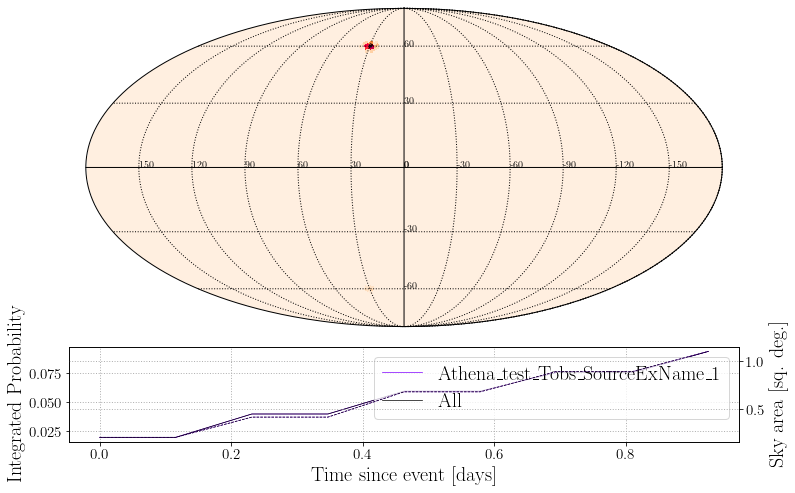

Total Cumulative Probability, Area: 0.09356, 1.10157


<Figure size 432x288 with 0 Axes>

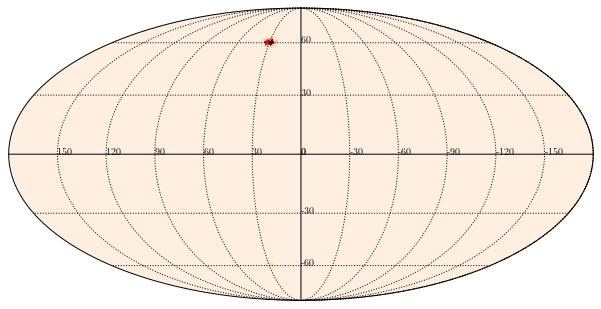

In [21]:

##### Plot schedule results using gwemopt internal plotting functions

# gwemtop uses different architectures so need to reorder some stuff before plotting (SYNEX equiv. function in progress)
go_params,map_struct=SYU.PrepareGwemoptDicts(Merger,Athenas_out[0])
coverage_struct=Athenas_out[0].detector_coverage_struct

# Plot coverage (SYNEX equiv. function in progress)
gwemopt.plotting.coverage(go_params, map_struct, coverage_struct, catalog_struct=None,plot_sun_moon=False)

# Plot dictionaries (SYNEX equiv. function in progress)
# gwemopt.plotting.scheduler(go_params,exposurelist,keys) -- this function is tricky to get right; adaptation to SYNEX on TO DO list.



#######
#
# NB: you can add go_params["doPlots"]=True, or add "doPlots":True option to Athena kwargs at initiation to output
#     all posible plots that gwemopt as internally.
#
#######
